# Week 4 Lab - Hypothesis Testing

# I. Introduction and Setup

# I.1 Introduction

> **Dataset Name:** `./data/assign_wk4/ToothGrowth.csv`
>
> The tooth growth dataset describes the length of the odontoblasts (teeth) in
> each of 10 guinea pigs at three Vitamin C dosage levels (`0.5`, `1`, and `2`
> mg) with two delivery methods (orange juice (*OJ*) or ascorbic acid (*VC*)).
>
> The file contains 60 observations of 3 variables:
> * **`len`**: Tooth length in millimeters
> * **`supp`**: Supplement type (VC or OJ)
> * **`dose`**: Dose in milligrams
>

# I.2 Python Setup

In [1]:
import datetime
import itertools
import numbers
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import matplotlib.pyplot
import scipy
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import typing
%matplotlib inline


## I.3 Data Acquisition

### I.3.1 Examine data file

In [2]:
!file data/assign_wk4/ToothGrowth.csv

data/assign_wk4/ToothGrowth.csv: CSV text


In [3]:
!wc -l data/assign_wk4/ToothGrowth.csv

61 data/assign_wk4/ToothGrowth.csv


### I.3.2 Import data

In [4]:
tooth_df = pd.read_csv('data/assign_wk4/ToothGrowth.csv', low_memory=False)
tooth_df.shape

(60, 4)

### I.3.3 Initial EDA

In [5]:
tooth_df.head()

,Unnamed: 0,len,supp,dose
0,1,4.2,VC,0.5
1,2,11.5,VC,0.5
2,3,7.3,VC,0.5
3,4,5.8,VC,0.5
4,5,6.4,VC,0.5


In [6]:
tooth_df.rename(columns={'Unnamed: 0': 'subject'}, inplace=True)
tooth_df.columns

Index(['subject', 'len', 'supp', 'dose'], dtype='object')

In [7]:
tooth_df[['len', 'dose']].describe().T

,count,mean,std,min,25%,50%,75%,max
len,60.0,18.813333,7.649315,4.2,13.075,19.25,25.275,33.9
dose,60.0,1.166667,0.628872,0.5,0.500,1.00,2.000,2.0


In [8]:
tooth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   subject  60 non-null     int64  
 1   len      60 non-null     float64
 2   supp     60 non-null     object 
 3   dose     60 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.0+ KB


In [9]:
tooth_df['supp'] = pd.Series(tooth_df.supp, dtype='string')
tooth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   subject  60 non-null     int64  
 1   len      60 non-null     float64
 2   supp     60 non-null     string 
 3   dose     60 non-null     float64
dtypes: float64(2), int64(1), string(1)
memory usage: 2.0 KB


## 1.4 Intermediate analysis of **`tooth_df`**

* The data frame imported correctly and matches the assignment description:    
  * `60` observations of `3` variables
  * **`len`**: Tooth length in millimeters
  * **`supp`**: Supplement type (VC or OJ)
  * **`dose`**: Dose in milligrams
* There are no null values, no data is missing or needs to be imputed
* Performed minor cleanup:    
  * changed column name **`Unnamed 0`** to **`subject`**
  * changed **`supp`** column type from `object` to `string`
* There is **no control group** present in the data set!

# 1. Graphically describe the dataset

> * This could include box plots, histograms, etc.
> * Provide a summary of your initial findings about the dataset.


In [10]:
def summary_graphs(df: pd.DataFrame, measurements, boxplot=True, hist=True, probplot=True, title_prefix=''):
    ''' Creates a figure with multiple plots for each requested measurement.

        Parameters
        ----------
        df: pd.DataFrame
            The source dataframe
        measurements: str | list
            One or more columns (measurements) to graph
        title_prefix: str (optional)
            A prefix to apply to each plot title

    '''
    measurements = measurements if type(measurements) is list else [measurements]
    num_measurements = len(measurements)
    figures_per_measurement = (1 if boxplot else 0) + (1 if hist else 0) + (1 if probplot else 0)
    figure_cols = figures_per_measurement
    figure_rows = int(math.ceil((num_measurements * figures_per_measurement) / figure_cols))

    # A personal figure size preference, based on the number or rows and cols:
    matplotlib.pyplot.figure(figsize=(4.0 * figure_cols, 4.0 * figure_rows))

    for i in range(num_measurements):
        column_name = measurements[i]
        column_values = df[column_name]

        if boxplot:
            matplotlib.pyplot.subplot(figure_rows,
                                    figure_cols,
                                    (i * figures_per_measurement) + 1,
                                    title=f'{title_prefix}{column_name} Boxplot')
            matplotlib.pyplot.boxplot(column_values)

        if hist:
            ax = matplotlib.pyplot.subplot(figure_rows,
                                        figure_cols,
                                        (i * figures_per_measurement) + 2,
                                        title=f'{title_prefix}{column_name} Histogram')
            sns.histplot(column_values, kde=True, ax=ax)
            matplotlib.pyplot.axvline(column_values.mean(), color='red')
            matplotlib.pyplot.axvline(column_values.median(), color='black', linestyle='dashed')

        if probplot:
            ax = matplotlib.pyplot.subplot(figure_rows,
                                        figure_cols,
                                        (i * figures_per_measurement) + 3,
                                        title=f'{title_prefix}{column_name} Probability')
            scipy.stats.probplot(column_values, plot=ax)

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

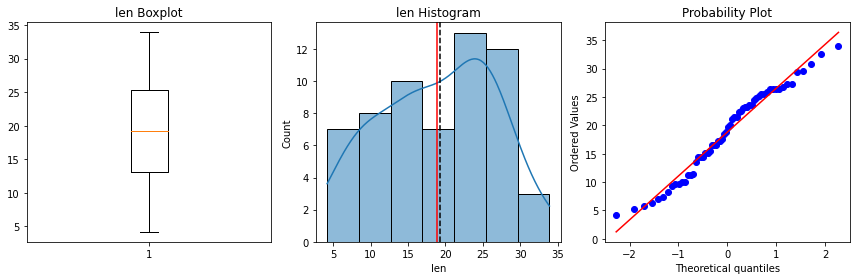

In [11]:
summary_graphs(tooth_df, 'len')

## Summary of initial findings

* Tooth length values vary: $4.2mm \le len_{tooth} \le 35.0mm$
* Tooth length does not appear to be normally distributed...
* ***However***, this view of tooth length includes all treatment effects!  Subsequent analysis will look at treatments separately.

# 2. Check of data normality

> * Graphically check for normality
> * Statistical test for normality

## 2.1 Overall Normality Tests

As mentioned in *Section 1: Graphically describe the dataset*, the overall distribution does not appear to be normal, per a visual examination of the tooth length histogram.

To assist with statistical tests for normality I created a convenience function which executes both *Shapiro-Wilk* and *D'Agostino* normality tests for a sample: **`statistical_normality_tests`**.  Then I run these tests against the overall sample of tooth lengths.

In [12]:
ALPHA = 0.05

def statistical_normality_test(values, prefix=''):
    ''' Convenience function which executes Shapiro-Wilk and D'Agostino normality tests.

        Parameters
        ----------
        values: list
            Collection of samples to be tested for normality
        prefix: str
            Optional prefix to prepend to result messages
    '''

    # Shapiro-Wilk tests the null hypothesis that the data was drawn from a
    # normal distribution (SciPy.org, n.d. 2)
    shapiro_stat, shapiro_p = scipy.stats.shapiro(values)
    if shapiro_p < ALPHA:
        print(f'{prefix}Shapiro-Wilk H0 rejected. Presume population IS NOT normally distributed [{shapiro_p:.2f} <= {ALPHA:.2f}]')
    else:
        print(f'{prefix}Shapiro-Wilk H0 not rejected.  Presume population IS normally distributed [{shapiro_p:.2f} > {ALPHA:.2f}]')


    # D'Agostion tests the null hypothesis that a sample comes from a normal
    # distribution by combining skew and kurtosis to produce an omnibus test of
    # normality (SciPy.org, n.d. 1)
    dagostino_stat, dagostino_p = scipy.stats.normaltest(values)
    if dagostino_p < ALPHA:
        print(f'{prefix}D\'Agostino\'s H0 rejected. Presume population IS NOT normally distributed [{dagostino_p:.2f} <= {ALPHA:.2f}]')
    else:
        print(f'{prefix}D\'Agostino\'s H0 not rejected.  Presume population IS normally distributed [{dagostino_p:.2f} > {ALPHA:.2f}]')

statistical_normality_test(tooth_df.len, 'Overall: ')


Overall: Shapiro-Wilk H0 not rejected.  Presume population IS normally distributed [0.11 > 0.05]
Overall: D'Agostino's H0 rejected. Presume population IS NOT normally distributed [0.04 <= 0.05]


### Summary of Overall Normality Tests

* The Shapiro-Wilk test **DID NOT reject $H_{0}$** indicating that we can presume tooth length comes from a normally distributed population.
* The D'Agostino test **DID reject $H_{0}$** indicating that we *can't* presume tooth length comes from a normally distributed population.
* However    
  * As mentioned in *Section I.4: Intermediate analysis of **`tooth_df`*** **there is no control group**
  * Therefore, as mentioned in *Section 1: Graphically describe the dataset*, tooth length **includes all treatment effects**
  * Assuming any of the treatments are effective, **we can reason that those subjects given an effective treatment would skew the results in one direction or another**, which may account for the failed D'Agostino test!

## 2.2 Per-Dosage Normality Tests

Based on the summary above, we now look at each dosage level separately to determine if they appear normal.  Unfortunately, this is only a substitue for the lack of a control group.

Below, we loop through each unique dosage level and perform the same tests we did for overall tooth length:
* Graphically check for normality
* Statistical test for normality


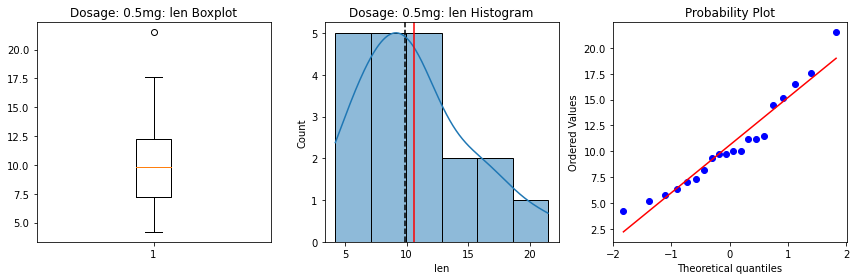

Dosage: 0.5mg: Shapiro-Wilk H0 not rejected.  Presume population IS normally distributed [0.25 > 0.05]
Dosage: 0.5mg: D'Agostino's H0 not rejected.  Presume population IS normally distributed [0.22 > 0.05]


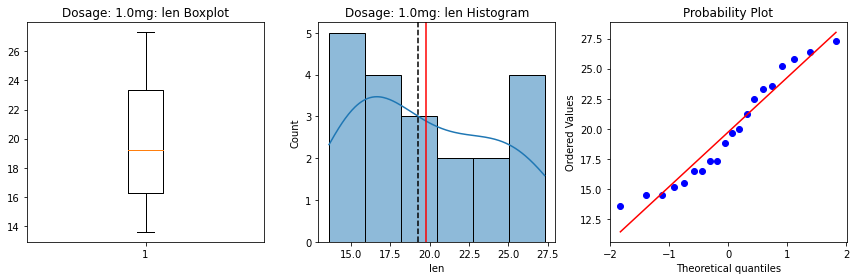

Dosage: 1.0mg: Shapiro-Wilk H0 not rejected.  Presume population IS normally distributed [0.16 > 0.05]
Dosage: 1.0mg: D'Agostino's H0 not rejected.  Presume population IS normally distributed [0.13 > 0.05]


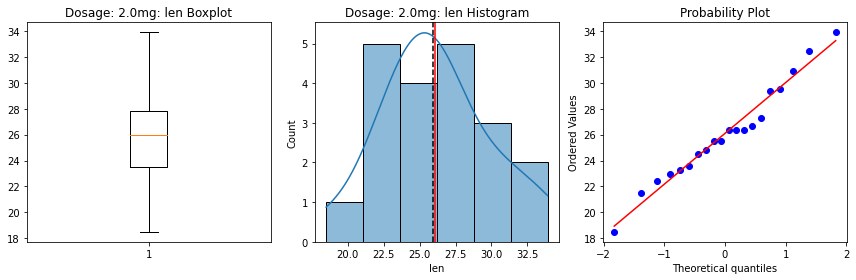

Dosage: 2.0mg: Shapiro-Wilk H0 not rejected.  Presume population IS normally distributed [0.90 > 0.05]
Dosage: 2.0mg: D'Agostino's H0 not rejected.  Presume population IS normally distributed [0.78 > 0.05]


In [13]:
for i in tooth_df.dose.unique():
    temp_df = tooth_df[(tooth_df.dose == i)]

    prefix = f'Dosage: {i:.1f}mg: '
    summary_graphs(temp_df, 'len', title_prefix=prefix)

    statistical_normality_test(temp_df.len, prefix)


### Summary of Per-Dosage Normality Tests

* **Dosage: 0.5mg**    
  * The Shapiro-Wilk test **DID NOT reject $H_{0}$** indicating that we can presume the $len_{tooth}$ comes from a normally distributed population.
  * The D'Agostino test **DID NOT reject $H_{0}$** indicating that we can presume the $len_{tooth}$ comes from a normally distributed population.
* **Dosage: 1.0mg**    
  * The Shapiro-Wilk test **DID NOT reject $H_{0}$** indicating that we can presume the $len_{tooth}$ comes from a normally distributed population.
  * The D'Agostino test **DID NOT reject $H_{0}$** indicating that we can presume the $len_{tooth}$ comes from a normally distributed population.
* **Dosage: 2.0mg**    
  * The Shapiro-Wilk test **DID NOT reject $H_{0}$** indicating that we can presume the $len_{tooth}$ comes from a normally distributed population.
  * The D'Agostino test **DID NOT reject $H_{0}$** indicating that we can presume the $len_{tooth}$ comes from a normally distributed population.

***Again, lacking a control group, we will use the above results as a proxy indication that we can proceed with hypothesis testing.***

# 3. Define Hypotheses

> * Be specific and clear in your definitions

The data set consists of two factors: **`dose`** (the dosage in `mg`) and **`supp`** (the supplement type, either 'OJ' or 'VC').  This yields *six* groups:

| Dosage vs Supplement Type | OJ           | VC           |
|:--------------------------|:-------------|:-------------|
| $0.5mg$                   | $OJ * 0.5mg$ | $VC * 0.5mg$ |
| $1.0mg$                   | $OJ * 1.0mg$ | $VC * 1.0mg$ |
| $2.0mg$                   | $OJ * 2.0mg$ | $VC * 2.0mg$ |


Because there are multiple factors, we will need multiple hypotheses pairs:
1. A hypothesis pair $\left(H1_{0}, H1_{a}\right)$ to account for *any* differences in the dataset
2. A hypothesis pair $\left(H2_{0}, H2_{a}\right)$ to account for effects of Supplement Type
3. A hypothesis pair $\left(H3_{0}, H3_{a}\right)$ to account for effects of Dosage
4. A hypothesis pair $\left(H4_{0}, H4_{a}\right)$ to account for interaction effects between Supplement Type and Dosage

## 3.1 Define a null and alternative hypothesis ($H_{0}$ and $H_{a}$) for the dataset

### 3.1.1 Overall Type Hypothesis
* $H1_{0}:$ If a sample of guinea pigs is given different Vitamin C supplement types and dosages, there will be *NO DIFFERENCE* between the mean tooth length of guinea pigs in each group.     
  $\left( \mu_{a}  =  \mu_{b}  =  \mu_{c}  =  \mu_{d}  =  \mu_{e}  =  \mu_{f} \right)$    
* $H1_{a}:$ If a sample of guinea pigs is given different Vitamin C supplement types and dosages, there will be *A STATISTICALLY SIGNIFICANT DIFFERENCE* between the mean tooth length of guinea pigs in each group.    
  $ (i, j) \in (a, b, c, d, e, f) \rightarrow \begin{cases} \mu_{i} \neq \mu_{j}  \\ i \neq j \end{cases} $   

### 3.1.2 Supplement Type Hypothesis
* $H2_{0}$: If a sample of guinea pigs is given different Vitamin C supplement types, there will be *NO DIFFERENCE* between the mean tooth length of guinea pigs in each group.     
  $\left( \mu_{supplement-type=OJ}  =     \mu_{supplement-type=VC} \right)$    
* $H2_{a}$: If a sample of guinea pigs is given different Vitamin C supplement types, there will be *A STATISTICALLY SIGNIFICANT DIFFERENCE* between the mean tooth length of guinea pigs in at least one group.     
  $\left( \mu_{supplement-type=OJ}  \neq  \mu_{supplement-type=VC} \right)$    

### 3.1.3 Dosage Hypothesis
* $H3_{0}$: If a sample of guinea pigs is given different Vitamin C doses, there will be *NO DIFFERENCE* between the mean tooth length of guinea pigs in each group.     
  $\left( \mu_{dosage=0.5mg}  =  \mu_{dosage=1.0mg}  =  \mu_{dosage=2.0mg} \right)$
* $H3_{a}$: If a sample of guinea pigs is given different Vitamin C doses, there will be *A STATISTICALLY SIGNIFICANT DIFFERENCE* between the mean tooth length of guinea pigs in at least one group.     
  $(i, j) \in (0.5, 1.0, 2.0) \rightarrow \begin{cases} \mu_{i} \neq \mu_{j}  \\ i \neq j \end{cases}$   

### 3.1.4 Interaction Hypothesis
* $H4_{0}$: If a sample of guinea pigs is given different Vitamin C supplement types and dosages, there will be *NO INTERACTION EFFECT* between the mean tooth length of guinea pigs in each group.     
* $H4_{a}$: If a sample of guinea pigs is given different Vitamin C supplement types and dosages, there will be *A STATISITCALLY SIGNIFICANT INTERACTION EFFECT* between the mean tooth length of guinea pigs in at least one group.     

## 3.2 State alpha

$\alpha = 0.05$

## 3.3 Calculate degrees of freedom and critical values

| Factor          | DoF Calculation                                                               | DoF Value                  | CV Lookup                                               | Critical Value                 |
|:----------------|:------------------------------------------------------------------------------|:---------------------------|:--------------------------------------------------------|:-------------------------------|
| Overall         | $n_{groups} - 1 = 6 - 1$                                                      | $df_{overall} = 5$         | $CV_{0.5}\left(df_{overall}, df_{error}\right)$         | $CV_{overall} = 2.386$         |
| Supplement Type | $n_{supplement-types} - 1 = 2 - 1$                                            | $df_{supplement-type} = 1$ | $CV_{0.5}\left(df_{supplement-type}, df_{error}\right)$ | $CV_{supplement-type} = 4.020$ |
| Dosage          | $n_{dosages} - 1 = 3 - 1$                                                     | $df_{dosage} = 2$          | $CV_{0.5}\left(df_{dosage}, df_{error}\right)$          | $CV_{dosage} = 3.168$          |
| Interaction     | $\left(n_{supplement-types} - 1\right)\left(n_{dosages} - 1\right) = 1 * 2$   | $df_{interaction} = 2$     | $CV_{0.5}\left(df_{interaction}, df_{error}\right)$     | $CV_{interaction} = 3.168$     |
| Error           | $N - n_{supplement-types} \cdot n_{dosages} = 60 - 2 * 3$                     | $df_{error} = 54$          |                                                         |                                |
| Total           | $N - 1 = 60 - 1$                                                              | $df_{total} = 59$          |                                                         |                                |

Critical values retrieved from [NIST.gov (n.d.)](#References)

## 3.4 State Decision Rule

### 3.4.1 Overall Decision Rule

Reject $H1_{0} \xRightarrow{iff} F_{overall} > 2.386$

### 3.4.2 Supplement Type Decision Rule

Reject $H2_{0} \xRightarrow{iff} F_{supplement-type} > 4.020$

### 3.4.3 Dosage Decision Rule

Reject $H3_{0} \xRightarrow{iff} F_{dosage} > 3.168$

### 3.4.4 Interaction Decision Rule

Reject $H4_{0} \xRightarrow{iff} F_{interaction} > 3.168$


In [14]:
# Create useful constants to match the table above ... use data from data frame
overall_dof = (tooth_df.supp.nunique() * tooth_df.dose.nunique()) - 1
supplement_type_dof = tooth_df.supp.nunique() - 1
dosage_dof = tooth_df.dose.nunique() - 1
interaction_dof = supplement_type_dof * dosage_dof
error_dof = tooth_df.len.count() - (tooth_df.supp.nunique() * tooth_df.dose.nunique())
total_dof = tooth_df.len.count() - 1

overall_cv = 2.386
supplement_type_cv = 4.020
dosage_cv = 3.168
interaction_cv = 3.168

# Compare values to hand-calculated table above
assert overall_dof == 5
assert supplement_type_dof == 1
assert dosage_dof == 2
assert interaction_dof == 2
assert error_dof == 54
assert total_dof == 59


# 4. Hypothesis Testing

> <br/>
> * Explain why you chose the test(s) you are using
> * Summarize your findings from the test(s) you performed
> <br/>
> <br/>

Recall from *Section 3: Define Hypothesis*:

> <br/>
>
> The data set consists of two factors: **`dose`** (the dosage in `mg`) and **`supp`** (the supplement type, either 'OJ' or 'VC').  This yields *six* groups:
> 
> | Dosage vs Supplement Type | OJ           | VC           |
> |:--------------------------|:-------------|:-------------|
> | $0.5mg$                   | $OJ * 0.5mg$ | $VC * 0.5mg$ |
> | $1.0mg$                   | $OJ * 1.0mg$ | $VC * 1.0mg$ |
> | $2.0mg$                   | $OJ * 2.0mg$ | $VC * 2.0mg$ |
>
> <br/>


According to [Regis.edu (n.d.)](#References)

> <br/>
> Note that analysis of variance (ANOVA) is used when there are more than two groups.
> <br/>
> <br/>

### Therefore, I am using Two-Factor ANOVA


In [15]:
# NOTE: scipy.stats.f_oneway can be used to perform a one-way ANOVA.
#       However, I wanted to 1) step thru the process slowly in order to learn
#       and 2) capture and display intermediate values.
#
#       This class manually performs ANOVA calculations and creates intermediate
#       data frames which can be used to describe the process.
class Anova(object):
    ''' Automates analysis of variance (ANOVA) calculations.
    '''

    def __init__(self, data_frame: pd.DataFrame, treatment_groups, measure_col, sse=None, dfd=None):
        '''
        Parameters
        ----------
        data_frame: pd.DataFrame
            The source dataframe, ungrouped
        treatment_groups: str | list
            One or more columns to group by
        measure_col: str
            The measurement column of interest
        sse: Number
            Optional sum of squares error to use.  If not provided, will be
            calculated from the given data
        dfd: Number
            Optional degrees of freedom in the denominator.  If not provided,
            will be calculated from the given data
        '''
        self._df = data_frame
        self._treatment_groups = treatment_groups if type(treatment_groups) is list else [treatment_groups]
        self._measure_col = measure_col
        self._grouped_df, self._intermediates = Anova.Intermediates(self._df,
                                                                    self._treatment_groups,
                                                                    measure_col)
        self._sse = sse
        self._dfd = dfd

    @property
    def df(self) -> pd.DataFrame:
        ''' Returns the original pd.DataFrame '''
        return self._df

    @property
    def grouped_df(self) -> pd.core.groupby.DataFrameGroupBy:
        ''' Returns a pd.core.groupby.DataFrameGroupBy grouped according to treatment_groups '''
        return self._grouped_df

    @property
    def intermediates(self) -> pd.DataFrame:
        ''' Returns a pd.DataFrame with values such as each group mean, group intermediate sum of squares... '''
        return self._intermediates

    @property
    def sum_of_squares_between(self) -> numbers.Number:
        ''' Returns the sum of squares between treatment groups '''
        return sum(self.intermediates['SSB (Intermediate)'])

    @property
    def sum_of_squares_errors(self) -> numbers.Number:
        ''' Returns the sum of squares between error/residuals '''
        return self._sse if self._sse else sum(self.intermediates['SSE (Intermediate)'])

    @property
    def sum_of_squares_total(self) -> numbers.Number:
        ''' Returns the sum of squares total '''
        return sum(self.intermediates['SST (Intermediate)'])

    @property
    def k(self) -> numbers.Number:
        ''' Returns the number of treatment groups '''
        return len(self.intermediates.index)

    @property
    def n(self) -> numbers.Number:
        ''' Returns the total number of measurements '''
        return len(self.df.index)

    @property
    def msb(self) -> numbers.Number:
        ''' Returns the mean squares between treatment groups '''
        return self.sum_of_squares_between / self.dfn

    @property
    def mse(self) -> numbers.Number:
        ''' Returns the mean squares error '''
        return self.sum_of_squares_errors / (self.n - self.k) # self.dfd

    @property
    def dfn(self) -> numbers.Number:
        ''' Returns the degrees of freedom of the numerator (MSB) '''
        return self.k - 1

    @property
    def dfd(self) -> numbers.Number:
        ''' Returns the degrees of freedom of the denominator (MSE) '''
        return self._dfd if self._dfd else self.n - self.k

    @property
    def dft(self) -> numbers.Number:
        ''' Returns the degrees of freedom total '''
        return self.n - 1

    @property
    def f(self) -> numbers.Number:
        ''' Returns the calculated F-value '''
        return self.msb / self.mse

    def scatter(self, x = None, hue = None, **kwargs):
        x = x if x else self._treatment_groups[0]
        hue = hue if hue else self._treatment_groups[1] if len(self._treatment_groups) > 1 else None

        return sns.scatterplot(x=x,
                               y='group mean',
                               data=self.intermediates,
                               hue=hue)

    @property
    def cv(self, q=0.95):
        ''' Returns the critical value'''
        return scipy.stats.f.ppf(q, dfn=self.dfn, dfd=54)

    @property
    def f_oneway(self):
        ''' Returns the F-value calculated using scipy'''
        len_samples = [g[self._measure_col].to_numpy() for _, g in self._grouped_df]
        return scipy.stats.f_oneway(*len_samples)

    @property
    def p(self):
        ''' Returns the P-value calculated using scipy'''
        return 1 - scipy.stats.f.cdf(self.f, dfn=self.dfn, dfd=self.dfd)

    def __str__(self):
        return f'SS={self.sum_of_squares_between:.2f}  df={self.dfn}  MS={self.msb:.2f}  F={self.f:.3f}  CV={self.cv:.3f}  P-Value:{self.p:.2f} [SciPy {self.f_oneway}]'

    def reject_h0(self):
        print(str(self))

        assert self.f > self.cv

        print(f'H0 rejected!  F-statistic ({self.f:.3f}) exceeds CV ({self.cv:.3f}) and is therefore statistically significant.')


    @staticmethod
    def Intermediates(data_frame: pd.DataFrame, treatment_groups, measure_col):
        _grouped = data_frame.groupby(treatment_groups)

        _overall_mean = data_frame[measure_col].mean()
        _values = {}

        for _group_name, _group in _grouped:
            _group_count    = _group[measure_col].count()
            _group_mean     = _group[measure_col].mean()
            _group_std      = _group[measure_col].std()

            _values[_group_name] = {
                'group count':  _group_count,
                'group mean':   _group_mean,
                'group std':    _group_std,

                # Weighted squared diff btwn treatment mean and overall mean
                'SSB (Intermediate)': _group_count * (_group_mean - _overall_mean)**2,

                # Sum of squared diff btwn items in treatment and treatment mean
                'SSE (Intermediate)': sum(_group[measure_col].subtract(_group_mean)**2),

                # Sum of squared diff btwn items in treatment and overall mean
                'SST (Intermediate)':  sum(_group[measure_col].subtract(_overall_mean)**2),
            }

            for i in range(len(treatment_groups)):
                _values[_group_name][treatment_groups[i]] = _group_name[i] if type(_group_name) is tuple else _group_name

        return _grouped, pd.DataFrame(_values).T


## 4.1 Overall Test Statistic Calculation

This overall test assesses whether there is a difference among the 6 group means (3 dosages x 2 supplement types).

In [16]:
# Use the Anova helper class
#    The data frame will be grouped by both 'dose' and 'supp'
tooth_overall_anova = Anova(tooth_df, ['dose', 'supp'], 'len', dfd=error_dof)

# Sanity check: verify that the Anova object calculations match hypothetical
# values from Section 3.3 above
#
# Second assertion form is for approximate floating point comparison
assert tooth_overall_anova.dfn == overall_dof
assert abs(tooth_overall_anova.cv - overall_cv) <= 0.001

tooth_overall_anova.intermediates

group count group mean group std SSB (Intermediate) SSE (Intermediate)  \
0.5 OJ          10      13.23  4.459709         311.736111            179.001   
    VC          10       7.98  2.746634        1173.611111             67.896   
1.0 OJ          10       22.7  3.910953         151.061778             137.66   
    VC          10      16.77  2.515309          41.752111             56.941   
2.0 OJ          10      26.06  2.655058         525.141778             63.444   
    VC          10      26.14  4.797731         536.800444            207.164   

       SST (Intermediate) dose supp  
0.5 OJ         490.737111  0.5   OJ  
    VC        1241.507111  0.5   VC  
1.0 OJ         288.721778  1.0   OJ  
    VC          98.693111  1.0   VC  
2.0 OJ         588.585778  2.0   OJ  
    VC         743.964444  2.0   VC

In [17]:
# Assert that the null hypothesis can be rejected and therefore the
try:
    tooth_overall_anova.reject_h0()
except AssertionError:
    print('Unable to reject the null hypothesis for the overall effect of any treatment!')


SS=2740.10  df=5  MS=548.02  F=41.557  CV=2.386  P-Value:0.00 [SciPy F_onewayResult(statistic=41.557178285255326, pvalue=2.503041690107327e-17)]
H0 rejected!  F-statistic (41.557) exceeds CV (2.386) and is therefore statistically significant.


<AxesSubplot:xlabel='dose', ylabel='group mean'>

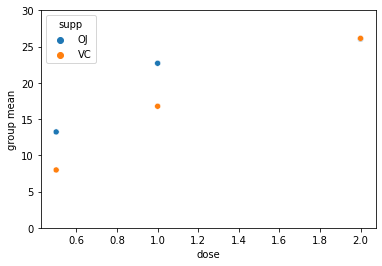

In [18]:
# Plot the means of each of the six groups
ax = matplotlib.pyplot.subplot(ylim=(0.0, 30.0))
tooth_overall_anova.scatter(ax=ax)

# NOTE: The mean values for 2.0mg OJ and 2.0mg VC are 26.06 and 26.14, respectively.
#       So, the orange marker in the upper right occludes the blue marker in the
#       same location.

### Overall Test Result

* **Statistically**:    
  * Critical Value: $F_{overall} \ge CV_{overall} \left( 41.56 \ge 2.39 \right)$
  * P-Value: Results are statistically significant with $p \lessapprox 0.0001$
* **Graphically**: We can also see from the scatterplot above that the treatments seem to have a significant effect on the group mean tooth length.

## 4.2 Supplement Type Statistic Calcuation

Assess the significance of the supplement type effect

In [19]:
tooth_supplement_type_anova = Anova(tooth_df, ['supp'], 'len', dfd=error_dof)

# Sanity check: verify that the Anova object calculations match hypothetical
# values from Section 3.3 above
#
# Second assertion form is for approximate floating point comparison
assert tooth_supplement_type_anova.dfn == supplement_type_dof
assert abs(tooth_supplement_type_anova.cv - supplement_type_cv) <= 0.001

tooth_supplement_type_anova.intermediates

,group count,group mean,group std,SSB (Intermediate),SSE (Intermediate),SST (Intermediate),supp
OJ,30,20.663333,6.605561,102.675,1265.369667,1368.044667,OJ
VC,30,16.963333,8.266029,102.675,1981.489667,2084.164667,VC


In [20]:
try:
    tooth_supplement_type_anova.reject_h0()
except AssertionError:
    print('Unable to reject the null hypothesis for supplement type effect!')

SS=205.35  df=1  MS=205.35  F=3.668  CV=4.020  P-Value:0.06 [SciPy F_onewayResult(statistic=3.668252541070971, pvalue=0.060393371224128745)]
Unable to reject the null hypothesis for supplement type effect!


<AxesSubplot:xlabel='supp', ylabel='group mean'>

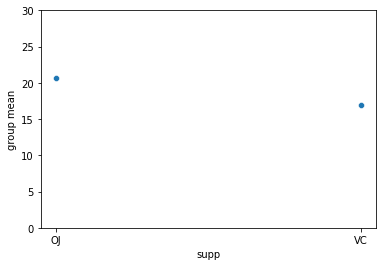

In [21]:
ax = matplotlib.pyplot.subplot(ylim=(0.0, 30.0))
tooth_supplement_type_anova.scatter(ax=ax)

### Supplement Type Test Result

* **Statistically**:    
  * Critical Value: $F_{supplement-type} \ngeq CV_{supplement-type} \left(3.67 \ngeq 4.020 \right)$
  * P-Value: Results are not statistically significant with $p \nleq 0.05$
* **Graphically**: From the scatterplot above, we can't conclude a significant effect from supplement type

## 4.3 Dosage Statistic Calculation

Assess the significance of the dosage effect

In [22]:
tooth_dose_anova = Anova(tooth_df, 'dose', 'len', dfd=error_dof)

# Sanity check: verify that the Anova object calculations match hypothetical
# values from Section 3.3 above
#
# Second assertion form is for approximate floating point comparison
assert tooth_dose_anova.dfn == dosage_dof
assert abs(tooth_dose_anova.cv - dosage_cv) <= 0.001

tooth_dose_anova.intermediates

,group count,group mean,group std,SSB (Intermediate),SSE (Intermediate),SST (Intermediate),dose
0.5,20.0,10.605,4.499763,1347.534722,384.7095,1732.244222,0.5
1.0,20.0,19.735,4.415436,16.989389,370.4255,387.414889,1.0
2.0,20.0,26.100,3.774150,1061.910222,270.6400,1332.550222,2.0


In [23]:
try:
    tooth_dose_anova.reject_h0()
except AssertionError:
    print('Unable to reject the null hypothesis for dosage effect!')


SS=2426.43  df=2  MS=1213.22  F=67.416  CV=3.168  P-Value:0.00 [SciPy F_onewayResult(statistic=67.41573785674247, pvalue=9.532727011699946e-16)]
H0 rejected!  F-statistic (67.416) exceeds CV (3.168) and is therefore statistically significant.


<AxesSubplot:xlabel='dose', ylabel='group mean'>

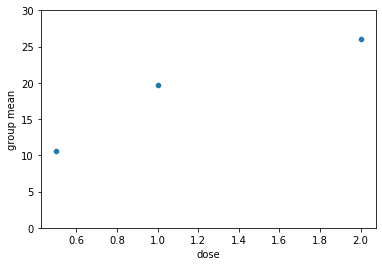

In [24]:
ax = matplotlib.pyplot.subplot(ylim=(0.0, 30.0))
tooth_dose_anova.scatter(ax=ax)


### Dosage Test Result

* **Statistically**:    
  * Critical Value: $F_{dosage} \ge CV_{dosage} \left( 67.416 \ge 3.168 \right)$
  * P-Value: Results are statistically significant with $p \lessapprox 0.0001$
* **Graphically**: We can also see from the scatterplot above that dosage seems to have a significant effect on the group mean tooth length.

## 4.4 Interaction Statistic Calculation

Assess the significance of the interaction of multiple effects

In [25]:
# Interaction sum of squares
tooth_interaction_ss = tooth_overall_anova.sum_of_squares_between     \
                    - tooth_supplement_type_anova.sum_of_squares_between \
                    - tooth_dose_anova.sum_of_squares_between

# Interaction mean squares
tooth_interaction_ms = tooth_interaction_ss / interaction_dof

# Calculate sum of squares total (sst)
sst = sum(tooth_df.len.sub(tooth_df.len.mean()) ** 2)

# Sum of squares error
sse = sst - tooth_supplement_type_anova.sum_of_squares_between \
          - tooth_dose_anova.sum_of_squares_between \
          - tooth_interaction_ss
    
mse = sse / error_dof

tooth_interaction_f = tooth_interaction_ms / mse

print(f'SS={tooth_interaction_ss:.2f}  df={interaction_dof}  MS={tooth_interaction_ms:.2f}  F={tooth_interaction_f:.2f}  CV={interaction_cv:.2f}')

try:
    assert tooth_interaction_f > interaction_cv
    print(f'H0 rejected!  F-statistic ({tooth_interaction_f:.3f}) exceeds CV ({interaction_cv:.3f}) and is therefore statistically significant.')
except AssertionError:
    print('Unable to reject the null hypothesis for interaction effect!')


SS=108.32  df=2  MS=54.16  F=4.11  CV=3.17
H0 rejected!  F-statistic (4.107) exceeds CV (3.168) and is therefore statistically significant.


### Interaction Test Result

* **Statistically**:    
  * Critical Value: $F_{interaction} \ge CV_{interaction} \left( 4.11 \ge 3.168 \right)$
  * P-Value: Results are statistically significant with $p \lt 0.05 \left( 0.02 \lt 0.05 \right)$
* **Graphically**: The graph in *Section 4.1: Overall Statistic Calculation* somewhat shows in interaction effect.

**However**, this result is much less significant (e.g., comparing $F_{interaction}$ to $CV_{interaction}$) than other results and is worth additional tests to verify the interaction effect.


# 5. Conclusion based on your analysis

> <br/>
> * Be sure to defend your conclusion. Include supporting information for your analysis.
> <br/>
> <br/>

Recall the Decision Rules from *Section 3.4*:

> <br/>
> 
> 1. Overall Decision Rule    
>    Reject $H1_{0} \xRightarrow{iff} F_{overall} > 2.386$
> 2. Supplement Type Decision Rule    
>    Reject $H2_{0} \xRightarrow{iff} F_{supplement-type} > 4.020$
> 3. Dosage Decision Rule    
>    Reject $H3_{0} \xRightarrow{iff} F_{dosage} > 3.168$
> 4. Interaction Decision Rule    
>    Reject $H4_{0} \xRightarrow{iff} F_{interaction} > 3.168$
> 
> <br/>
> <br/>

## 5.1 Overall Conclusion: Reject $H1_{0} \because F_{overall} \ge CV_{overall}$
* Results:    $F_{overall} \ge CV_{overall} \left( 41.56 \ge 2.386 \right)$    
* Conclusion: $H1_{a}$ is favored over $H1_{0}$    
* $H1_{a}$:   If a sample of guinea pigs is given different Vitamin C supplement types and dosages, there will be *A STATISTICALLY SIGNIFICANT DIFFERENCE* between the mean tooth length of guinea pigs in each group.     

## 5.2 Supplement Type Conclusion: Retain $H2_{0} \because F_{supplement-type} \ngeq CV_{supplement-type}$
* Results:    $F_{supplement-type} \ngeq CV_{supplement-type} \left(3.67 \ngeq 4.020 \right)$    
* Conclusion: $H2_{0}$ is favored over $H2_{a}$    
* $H2_{0}$:   If a sample of guinea pigs is given different Vitamin C supplement types, there will be *NO DIFFERENCE* between the mean tooth length of guinea pigs in each group.     


## 5.3 Dosage Conclusion: Reject $H3_{0} \because F_{dosage} \ge CV_{dosage}$
* Results:    $F_{dosage} \ge CV_{dosage} \left( 63.87 \ge 3.168 \right)$    
* Conclusion: $H3_{a}$ is favored over $H3_{0}$    
* $H3_{a}$:   If a sample of guinea pigs is given different Vitamin C doses, there will be *A STATISTICALLY SIGNIFICANT DIFFERENCE* between the mean tooth length of guinea pigs in each group.     

## 5.4 Interaction Conclusion: Reject $H4_{0} \because F_{interaction} \ge CV_{interaction}$
* Results:    $F_{interaction} \ge CV_{interaction} \left( 4.11 \ge 3.168 \right)$    
* Conclusion: $H4_{a}$ is favored over $H4_{0}$    
* $H4_{a}$:   If a sample of guinea pigs is given different Vitamin C supplement types and dosages, there will be *A STATISITCALLY SIGNIFICANT INTERACTION EFFECT* between the mean tooth length of guinea pigs in each group.     


# 6. Refine your initial hypothesis and repeat steps 3 through 5

> <br/>
>
> * Explain why you chose the test(s) you are using
> * Summarize your findings from the test(s) you performed
>
> <br/>

For this refinement, I will use Independent Samples T-Test to compare individual
groups directly with each other.  Furthermore, I will use the one-tailed
alternative in order to test directional hypotheses.

## 6.1 Define a null and alternative hypothesis ($H_{0}$ and $H_{a}$) for the dataset

### 6.1.1 Hypothesis: 1.0mg dose
* $H1_{0}:$ If a sample of guinea pigs is given $1.0mg$ Vitamin C dosages via OJ, there will be *NO DIFFERENCE* between the mean tooth length of guinea pigs given $0.5mg$.     
  $\left( \mu_{0.5}  =  \mu_{1.0} \right)$    
* $H1_{a}:$ If a sample of guinea pigs is given $1.0mg$ Vitamin C dosages via OJ, the mean tooth length will *BE STATISTICALLY GREATER THAN* guinea pigs given $0.5mg$.    
  $\left( \mu_{0.5}  \lt  \mu_{1.0}  \right)$   

### 6.1.2 Hypothesis: 2.0mg dose
* $H2_{0}:$ If a sample of guinea pigs is given $2.0mg$ Vitamin C dosages via OJ, there will be *NO DIFFERENCE* between the mean tooth length of guinea pigs given $1.0mg$.     
  $\left( \mu_{1.0}  =  \mu_{2.0} \right)$    
* $H2_{a}:$ If a sample of guinea pigs is given $2.0mg$ Vitamin C dosages via OJ, the mean tooth length will *BE STATISTICALLY GREATER THAN* guinea pigs given $1.0mg$.    
  $\left( \mu_{1.0}  \lt  \mu_{2.0}  \right)$   

## 6.2 State alpha

~~Two-sided test:~~ $\alpha = 0.05$

One-sided test: $\alpha = 0.025$

## 6.3 Calculate degrees of freedom and critical values

Independent T-Test: $df = (n_{1} - 1) + (n_{2} - 1)$

### 6.3.1 Degrees of freedom and critical values: 1.0mg dose

$df_{1.0mg} = (n_{1} - 1) + (n_{2} - 1) = (10 - 1) + (10 - 1) = 18$

$CV_{1.0mg} = 2.101$

[(SJSU.edu, n.d.)](#References)

### 6.3.2 Degrees of freedom and critical values: 2.0mg dose

$df_{2.0mg} = (n_{1} - 1) + (n_{2} - 1) = (10 - 1) + (10 - 1) = 18$

$CV_{1.0mg} = 2.101$

[(SJSU.edu, n.d.)](#References)

## 6.4 Hypothesis Testing



In [26]:
ALPHA = 0.025

dose05_n = 10
dose05_df = dose05_n - 1

dose10_n = 10
dose10_df = dose10_n - 1
dose10_cv = 2.101

dose20_n = 10
dose20_df = dose20_n - 1
dose20_cv = 2.101


### 6.4.1 Statistic Calculation: 1.0mg dose vs 0.5mg dose

In [27]:
df_05 = tooth_df[(tooth_df.dose == 0.5) & (tooth_df.supp == 'OJ')]
df_10 = tooth_df[(tooth_df.dose == 1.0) & (tooth_df.supp == 'OJ')]

# Sum of squares for each sample
ss_05 = sum(df_05.len.sub(df_05.len.mean()).pow(2))
ss_10 = sum(df_10.len.sub(df_10.len.mean()).pow(2))

# Pooled sum of squares
ssp_05_10 = (ss_05 + ss_10) / (dose05_df + dose10_df)
dose10_t = (df_10.len.mean() - df_05.len.mean()) / math.sqrt((ssp_05_10 / dose10_n) + (ssp_05_10 / dose05_n))

print(f'SS(0.5mg)={ss_05:.2f}  SS(1.0mg)={ss_10:.2f}  T={dose10_t:.2f}  CV={dose10_cv:.2f}')

try:
    assert dose10_t > dose10_cv
    print(
        f'H0 rejected!  T-statistic ({dose10_t:.3f}) exceeds CV ({dose10_cv:.3f}) and is therefore statistically significant.')
except AssertionError:
    print('Unable to reject the null hypothesis!')


SS(0.5mg)=179.00  SS(1.0mg)=137.66  T=5.05  CV=2.10
H0 rejected!  T-statistic (5.049) exceeds CV (2.101) and is therefore statistically significant.


In [28]:
# Check work using scipy.stats.ttest_ind:
scipy.stats.ttest_ind(df_10.len.to_numpy(), df_05.len.to_numpy(), alternative='greater')


Ttest_indResult(statistic=5.048634657337134, pvalue=4.178779640721887e-05)

### 6.4.2 Statistic Calculation: 2.0mg dose vs 1.0mg dose

In [29]:
df_20 = tooth_df[(tooth_df.dose == 2.0) & (tooth_df.supp == 'OJ')]

# Sum of squares for each sample
ss_20 = sum(df_20.len.sub(df_20.len.mean()).pow(2))

# Pooled sum of squares
ssp_10_20 = (ss_10 + ss_20) / (dose10_df + dose20_df)
dose20_t = (df_20.len.mean() - df_10.len.mean()) / math.sqrt((ssp_10_20 / dose20_n) + (ssp_10_20 / dose10_n))

print(f'SS(1.0mg)={ss_10:.2f}  SS(2.0mg)={ss_20:.2f}  T={dose20_t:.2f}  CV={dose20_cv:.2f}')

try:
    assert dose20_t > dose20_cv
    print(f'H0 rejected!  T-statistic ({dose20_t:.3f}) exceeds CV ({dose20_cv:.3f}) and is therefore statistically significant.')
except AssertionError:
    print('Unable to reject the null hypothesis!')


SS(1.0mg)=137.66  SS(2.0mg)=63.44  T=2.25  CV=2.10
H0 rejected!  T-statistic (2.248) exceeds CV (2.101) and is therefore statistically significant.


In [30]:
# Check work using scipy.stats.ttest_ind:
scipy.stats.ttest_ind(df_20.len.to_numpy(), df_10.len.to_numpy(), alternative='greater')


Ttest_indResult(statistic=2.2477612380279295, pvalue=0.018681397928321915)

## 6.5 Refinement Outcome

> <br/>
> * How did the outcome(s) change between your original Ho/Ha and your refined Ho/Ha?
> <br/>
> <br/>

With the refined hypothesis, we provded:
* $1.0mg$ doses of Vitamin C using OJ yielded greater mean tooth length than $0.5mg$ doses using the same supplement type.
* $2.0mg$ doses of Vitamin C using OJ yielded greater mean tooth length than $1.0mg$ doses using the same supplement type.

Both of these hypotheses are more specific than the previous ANOVA hypotheses.

# Appendix: Test Anova Class

The data from this test case was used to test the **`Anova`** class above.

[BU.edu (n.d.)](#References)

> <br/>
> Consider the clinical trial outlined above in which three competing treatments for joint pain are
> compared in terms of their mean time to pain relief in patients with osteoarthritis.
> Because investigators hypothesize that there may be a difference in time to pain relief in men
> versus women, they randomly assign 15 participating men to one of the three competing treatments
> and randomly assign 15 participating women to one of the three competing treatments
> (i.e., stratified randomization).
> Participating men and women do not know to which treatment they are assigned. They are instructed
> to take the assigned medication when they experience joint pain and to record the time, in
> minutes, until the pain subsides.
> The data (times to pain relief) are shown below and are organized by the assigned treatment and
> gender of the participant.
> <br/>
> <br/>

<br/>

| Treatment | Male | Female |
|:----------|:-----|:-------|
|     A     | 12   | 21     |
|           | 15   | 19     |
|           | 16   | 18     |
|           | 17   | 24     |
|           | 14   | 25     |
|     B     | 14   | 25     |
|           | 17   | 20     |
|           | 19   | 23     |
|           | 20   | 27     |
|           | 17   | 25     |
|     C     | 25   | 37     |
|           | 27   | 34     |
|           | 29   | 36     |
|           | 24   | 26     |
|           | 22   | 29     |



In [31]:
sample_anova_df = pd.DataFrame({'Treatment': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C'],
                                'Gender':    ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
                                'Time':      [12,  15,  16,  17,  14,  14,  17,  19,  20,  17,  25,  27,  29,  24,  22,  21,  19,  18,  24,  25,  21,  20,  23,  27,  25,  37,  34,  36,  26,  29]})

sample_anova_model = Anova(sample_anova_df, ['Treatment', 'Gender'], 'Time')
sample_anova_model.intermediates

# Use values from the web site to verify we've performed the calculations
# correctly
assert abs(sample_anova_model.sum_of_squares_between - 967.0) < 0.5
assert sample_anova_model.dfn == 5
assert abs(sample_anova_model.msb - 193.4) < 0.5
assert abs(sample_anova_model.f - 20.7) < 0.5

<AxesSubplot:xlabel='Treatment', ylabel='group mean'>

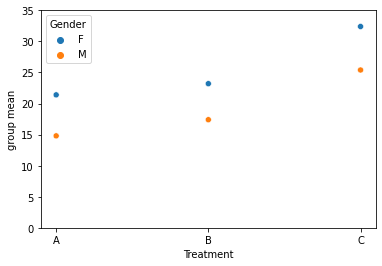

In [32]:
ax = matplotlib.pyplot.subplot(ylim=(0.0, 35.0))
sample_anova_model.scatter(ax=ax)

In [33]:
sample_anova_treatment = Anova(sample_anova_df, 'Treatment', 'Time', dfd=24)
sample_anova_gender = Anova(sample_anova_df, 'Gender', 'Time', dfd=24)

# Use values from the web site to verify we've performed the calculations
# correctly
assert abs(sample_anova_treatment.sum_of_squares_between - 651.5) < 0.5
assert sample_anova_treatment.dfn == 2
assert abs(sample_anova_treatment.msb - 325.7) < 0.5
assert abs(sample_anova_treatment.f - sample_anova_treatment.f_oneway[0]) < 0.5

assert abs(sample_anova_gender.sum_of_squares_between - 313.6) < 0.5
assert sample_anova_gender.dfn == 1
assert abs(sample_anova_gender.msb - 313.6) < 0.5
assert abs(sample_anova_gender.f - sample_anova_gender.f_oneway[0]) < 0.5


In [34]:
# Interaction sum of squares
sample_anova_interaction_ss = sample_anova_model.sum_of_squares_between         \
                                - sample_anova_treatment.sum_of_squares_between \
                                - sample_anova_gender.sum_of_squares_between

# Interaction mean square
sample_anova_interaction_ms = sample_anova_interaction_ss / 2

# Sample Anova sum of squares total
sample_anova_sst = sum(sample_anova_df.Time.sub(sample_anova_df.Time.mean()) ** 2)

# Sample Anova sum of squares error
sample_anova_sse = sample_anova_sst - sample_anova_treatment.sum_of_squares_between - \
    sample_anova_interaction_ss - \
    sample_anova_gender.sum_of_squares_between

# Sample Anova mean square error
sample_anova_mse = sample_anova_sse / 24

# Interaction F statistic
sample_anova_interaction_f = sample_anova_interaction_ms / sample_anova_mse

# Use values from the web site to verify we've performed the calculations
# correctly
assert abs(sample_anova_interaction_ss - 1.9) < 0.5
assert abs(sample_anova_interaction_ms - 0.9) < 0.5
assert abs(sample_anova_interaction_f - 0.1) < 0.5


# References

* BU.edu (n.d.).  Two-factor ANOVA.  Retrieved from https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_HypothesisTesting-ANOVA/BS704_HypothesisTesting-Anova5.html
* NIST.gov (n.d.).  Upper critical values of the F distribution.  Retrieved from https://www.itl.nist.gov/div898/handbook/eda/section3/eda3673.htm
* Regis.edu (n.d.).  Week 4: Inferential statistics ver2.  Retrieved from https://worldclass.regis.edu/d2l/le/content/277913/viewContent/4052400/View
* SciPy.org (n.d. 1).  scipy.stats.normaltest.  Retrieved from https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest
* SciPy.org (n.d. 2).  scipy.stats.shapiro.  Retrieved from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro
* SJSU.edu (n.d.).  T-table.  Retrieved from https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf